# Kommentaaride süntees

See notebook sisaldab loogikat ja koodi selleks, et male käigu `string` põhjal sünteesida kommentaar, milline käik aset võttis.

Käigu kirjelduse sisendiks on käigu alguse ruut ja käigu lõpu ruut.<br>
Formaat: `<alguse täht><alguse nr><lõpp täht><lõpp nr>`<br>
Näiteks: `g1f3`

<b>Hetkene idee:</b>
- Eeldame, et käik on valideeritud
- Peale käigu tegemist..
    - ..vaata mis nupp liigub
    - ..vaata kust kuhu liigutakse
    - ..kontrolli kas antakse tuld
    
<font color=blue><b>TODO:</b> Teha korda kui lõplik variant olemas.</font>

In [1]:
import chess
import json
import requests
import IPython.display as ipd

## Male laua kasutamine ja set-up

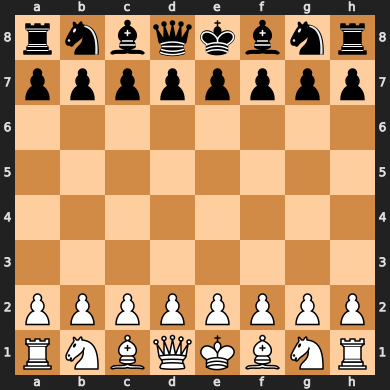

In [2]:
# Laua paika panemine
board = chess.Board()

board

Kasulik termin: <b>pseudo-legal</b> käik - <i>"Pseudo-legal moves might leave or put the king in check, but are otherwise valid. Null moves are not pseudo-legal. Castling moves are only included if they are completely legal."</i>

Kasulikud käsud:
- `board.push_uci("g1f3")` - tee käik g1 -> f3 (ei kontrolli valiidsust)
- `board.pop()` - võta viimane käik tagasi ja tagasta see
- `board.is_capture(move)` - tagastab bool, et kas pseudo-legal käik võtab nupu
- `board.is_check()` - tagastab bool, et kas praegu käiv pool on tule all
- `board.piece_at(square)` - tagastab ruudul oleva nupu
- `board.piece_type_at(sqsuare)` - tagastab ruudul oleva nupu tüübi
- `board.color_at(square)` - tagastab ruudul oleva nupu värvi
- `board.peek()` - tagastab viimase käigu
- `board.turn` - tagastab True kui on valge käik

<font color=blue><b>TODO:</b> Kuidas saada, et mis nupp ära võeti?</font>

## Neurokõne

Käigu `string` põhjal saab genereerida neurokõne, mis kommenteerib tehtud käiku.

Erinevad lause struktuurid mida kasutada:
- `<mängija värv>` `<nupp>` käis ruudult `<algus ruut>` ruudule `<lõpu ruut>`.
- `<mängija värv>` võttis ära `<vastase värvi>` `<võetud nupp>`.
- `<mängija värv>` annab vastasele tuld.
- `<mängija värv>` võitis mängu.
- Mäng jäi viiki.

<font color=blue><b>TODO:</b> Kas on mingeid käike veel, mida katma peaks?</font>

In [3]:
# Neurokõne genereerimise näide
payload = {'text': 'Must ratsu käis ruudult b8 ruudule c6', 'speaker': 'Albert'}
headers = {"Content-Type": "application/json"};
r = requests.post("https://api.tartunlp.ai/text-to-speech/v2", data=json.dumps(payload), headers=headers)
ipd.Audio(data=r.content)

In [4]:
pieces = {"P":"Valge ettur", "N":"Valge ratsu", "B":"Valge oda",
          "R":"Valge vanker", "Q":"Valge lipp", "K":"Valge kuningas",
          "p":"Must ettur", "n":"Must ratsu", "b":"Must oda",
          "r":"Must vanker", "q":"Must lipp", "k":"Must kuningas"}
takenPieces = {"P":"Valge etturi", "N":"Valge ratsu", "B":"Valge oda",
          "R":"Valge vankri", "Q":"Valge lipu", "K":"Valge kuninga",
          "p":"Musta etturi", "n":"Musta ratsu", "b":"Musta oda",
          "r":"Musta vankri", "q":"Musta lipu", "k":"Musta kuninga"}

def resolveOutcomeComment(outcome):
    winner = outcome.winner
    if winner is None:
        return "Mäng jäi viiki."
    elif winner:
        return "Valge võitis mängu."
    else:
        return "Must võitis mängu."
    
def describeMoveComment(board, move):
    piece = board.piece_at(move.to_square)
    result = pieces[piece.symbol()]
    result += " käis ruudult "
    result += chess.square_name(move.from_square)
    result += " ruudule "
    result += chess.square_name(move.to_square)
    return result

def describeTakenPiece(board, move):
    result = ""
    board.pop()
    takenPiece = board.piece_at(move.to_square)
    if takenPiece is not None:
        if board.turn:
            result = "Valge võttis ära " + takenPieces[takenPiece.symbol()]
        else:
            result = "Must võttis ära " + takenPieces[takenPiece.symbol()]
    board.push(move)
    return result

def describeCheck(board):
    result = ""
    board.turn = not board.turn
    if board.is_check():
        if board.turn:
            result = "Must annab valgele tuld."
        else:
            result = "Valge annab mustale tuld."
    board.turn = not board.turn
    return result
    
# Assumes the move has already been made
# Assues it is still the turn of the player who made the move
def buildComment(board):
    # Variables
    result = ""
    move = board.peek()
    outcome = board.outcome()
    
    # Describe outcome if any
    if (outcome is not None): # game has ended
        result += resolveOutcomeComment(outcome) + " "
    
    # Describe move
    result += describeMoveComment(board, move) + ". "
    
    # Check and describe taken pieces
    result += describeTakenPiece(board, move)
    
    # Check for check
    result += describeCheck(board)
    
    return result

In [8]:
# Simple demo

moves = ["e2e4", "e7e5", "f1c4", "b8c6", "d1h5", "g8f6", "h5f7"]

board.reset()

for m in moves:
    board.push_uci(m)
    print(buildComment(board)+"\n")
    print(board)
    print("- - - - - - - - - - - - - - - - - - - - - - - - - -")

Valge ettur käis ruudult e2 ruudule e4. 

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
- - - - - - - - - - - - - - - - - - - - - - - - - -
Must ettur käis ruudult e7 ruudule e5. 

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
- - - - - - - - - - - - - - - - - - - - - - - - - -
Valge oda käis ruudult f1 ruudule c4. 

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K . N R
- - - - - - - - - - - - - - - - - - - - - - - - - -
Must ratsu käis ruudult b8 ruudule c6. 

r . b q k b n r
p p p p . p p p
. . n . . . . .
. . . . p . . .
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K . N R
- - - - - - - - - - - - - - - - - - - - - - - - - -
Valge lipp käis ruudult d1 ruudule h5. 

r . b q k b n r
p p p p . p p p
. . n . . . . .
. . . . p . . Q
. . B . P .